# Recommender Systems with Graph Neural Networks in PyG

By Derrick Li, Peter Maldonado, Akram Sbaih as part of the Stanford CS224W course project.

In this tutorial, we implement two GNN recommender system architectures, LightGCN and NGCF, in PyG and apply them to the MovieLens 100K dataset.

## Setup

First, we'll install the necessary packages.

In [ ]:
%%capture
# Environment Setup (note that capture silences the console output)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!git clone https://github.com/pmaldonado/cs224w-project-data.git

Next, let's import all of the modules that we'll use in this notebook.

In [ ]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

Lastly, we should double check that our environment is working as expected.

In [ ]:
torch_geometric.__version__

'2.4.0'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset and Preprocessing

For this tutorial, we’ll be using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/), which contains 100,000 ratings by 943 users of 1682 items (movies). To ensure the quality of the dataset, each user has rated at least 20 movies.

We’ll focus on the interactions between users and items, in this case user ratings of movies, but the dataset also provides metadata about users and movies, such as user demographics and movie titles, release dates, and genres. T

The user ratings of movies form a bipartite graph, which we can apply graph machine learning methods to recommend new movies to users.


In [ ]:
columns_name=['user_id','item_id','rating','timestamp']
df1 = pd.read_csv("./cs224w-project-data/ml-100k/u.data",sep="\t",names=columns_name)
print(len(df1))
display(df1.head(5))

100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
df = df1.head(1000)
len(df)


1000

We only want to use high ratings as interactions in order to predict which movies a user will enjoy watching next.

In [ ]:
# How many ratings are a 3 or above?
df = df[df['rating']>=3]
print(len(df))

82520


In [ ]:
# What's the distribution of highly rated movies?
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

In [ ]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [ ]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  800
Test Size :  200


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [ ]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

, this code is creating numerical indices for user and item IDs, which will be used as inputs for a recommendation model. The LabelEncoder helps ensure that these categorical values are represented as numbers that the model can work with

In [ ]:
# Get the unique user IDs and item IDs in the training data
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

# Print the number of unique user IDs and item IDs in the training data
print("Number of unique users in training data:", len(train_user_ids))
print("Number of unique items in training data:", len(train_item_ids))

# Filter the test data to keep only interactions present in the training data
# This ensures that we're testing the model on data it has seen before
test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) &
    (test_df['item_id'].isin(train_item_ids))
]

# Print the length of the original test data (before filtering)
# This helps us understand how much data was retained after filtering
print("Length of test data after filtering:", len(test_df))


This process ensures that the test data only contains user-item interactions that the recommendation system has already seen during training. It's like making sure the test questions are based on the material the system has already studied.

In [ ]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

The purpose is to convert the categorical user IDs and item IDs in the test_df DataFrame into numerical indices using the transform method

In [ ]:
# Get the number of unique user indices in the training data
n_users = train_df['user_id_idx'].nunique()

# Get the number of unique item indices in the training data
n_items = train_df['item_id_idx'].nunique()

# Print the number of unique users and items
print("Number of Unique Users: ", n_users)
print("Number of Unique Items: ", n_items)


In [ ]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  233
Number of unique Items :  473


### Minibatch Sampling

Explain the scheme of minibatch positive and negative sample in some amount of prose.

We need to add `n_usr` to the sampled positive and negative items, since each node must have a unique id when using PyG.

In [ ]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([  2,  24,  37,  80,  99, 108, 131, 132, 136, 160, 173, 174, 189, 190,
         191, 212]),
 tensor([371, 625, 422, 443, 435, 419, 367, 250, 515, 276, 516, 673, 621, 390,
         430, 412]),
 tensor([552, 338, 325, 469, 653, 678, 394, 555, 624, 378, 391, 398, 489, 379,
         686, 394]))

data_loader function generates training batches for a recommendation model. It selects a batch of users, samples positive items for those users from their interacted items, and samples negative items that are not in the list of positive items for each user. This process ensures that the model has both positive and negative interactions for training, which is crucial for learning to make accurate recommendations

Minibatch sampling means training a model using small groups of data (minibatches) instead of using all the data at once. This helps make training faster, adds some randomness, and can improve the model's performance.

## Edge Index

PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add `n_users` to the item tensor to ensure that every node in the graph has a unique identifier.

In [ ]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 64, 217,  35,  ..., 503, 662, 477],
        [613, 241, 420,  ...,  90, 141, 232]])

This tensor represents the connections (edges) between users and items in the graph, which is a common format used in Graph Neural Networks (GNNs)
It's essential for GNNs to understand the relationships between users and items when making recommendations.

Let's confirm that the first and last edges match the middle two edges, but with the order of nodes swapped.

In [ ]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([477, 232]), tensor([ 64, 613]))

This code is extracting the indices of nodes connected by the last edge and the first edge in the train_edge_index tensor. It helps us understand which nodes are connected by these edges.

In [ ]:
train_edge_index[:, len(train)-1], train_edge_index[:, len(train)]

(tensor([232, 477]), tensor([613,  64]))

## Model Architecture

First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.

### LightGCN Convolutional Layer

The LightGCN architecture is governed by the following rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.


Briefly explain how the `MessagePassing` class works (look at colabs)

We can specify the type of aggregation our `MessagePassing` layer should use by passing in an `aggr=` argument in the layer initialization. Here we use `add` to specify summation aggregation of messages.

Note that we could have manually defined our aggregation function by defining a function explicitly in the class:
```
def aggregate(self, x, messages, index):
  return torch_scatter.scatter(messages, index, self.node_dim, reduce="sum")
```
The `torch_scatter.scatter` function enables us to aggregate messages being sent to the same node. The `reduce=` argument specifies how to aggregate, while `index` has the same length as the `messages` tensor and maps from message to destination node.

LightGCN is a simplified way to make recommendations, like suggesting movies or products based on what users have liked. It's designed to be fast and good for big groups of users and items. It's like a lighter version of a more complex method called Graph Convolutional Networks (GCNs), with fewer steps to make things simple and efficient. It's great for making recommendations in big systems where lots of users and items are involved.

Traditional GCNs: Complex, slower, suitable for various graph tasks.
LightGCN: Simple, fast, specialized for recommendation systems.

In [ ]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')#indicating that the aggregation of messages during message passing will be a summation.

  def forward(self, x, edge_index):#The forward method is the core of the layer, where the message passing operation occurs.
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [ ]:
# Define a class for the LightGCN convolutional layer, which inherits from MessagePassing
class LightGCNConv(MessagePassing):
  # Constructor for the LightGCNConv layer
  def __init__(self, **kwargs):
    super().__init__(aggr='add')  # We set the aggregation method to 'add'

  # Forward pass function for the layer
  def forward(self, x, edge_index):
    # Compute normalization for the messages based on the edge_index (connections)
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)  # Compute the degree of each target node (to_)
    deg_inv_sqrt = deg.pow(-0.5)  # Calculate the inverse square root of the degrees
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0  # Handle cases where the degree is zero (to avoid division by zero)
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]  # Normalize the messages based on the degree information

    # Start propagating the normalized messages (no updates after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  # Function to compute the actual message content (scaled by the normalization)
  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j


LightGCNConv, which is a custom message-passing layer for the LightGCN model,

We prepare the layer for message passing using the LightGCNConv class.
During the forward pass, we calculate normalization factors for messages based on the graph's structure.
We then send these normalized messages from one node to another, but we don't update the nodes' embeddings.
The message passing process is performed using the propagate method.
The final output is the messages that have been propagated.

Let's test out our implementation of the LightGCN convolution by applying it to a small bipartite graph.

This sample graph is undirected, and node 0 is connected to nodes 2 and 3 while node 1 is connected to 3 and 4.

Sure! Imagine we have a network of users and items, like a social network but for recommending products. Each connection between a user and an item represents a user's interaction with that item (like giving it a rating or buying it).

This code defines a special "operation" we can use in this network. It helps us spread useful information from one user or item to another. It's like telling your friends about a great movie you watched, and they tell their friends, and so on. We do this in a way that takes into account how many connections each user or item has, so it's fair and balanced.

This operation helps us make better recommendations without changing the original information about each user or item. It's like giving everyone a little bit of helpful advice based on what others liked, but we don't change who they are or what they liked. It's a key part of a system that helps us recommend things more accurately.

In [ ]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

Notice how each node has an initial feature vector corresponding to a one-hot encoding at the index of their id.

As we expected, node 0 received messages (and so has non-zero features at the corresponding indicies) from nodes 2 and 3. We can easily verify that nodes 1, 2, 3, and 4 also received messages from their precisely neighbors.

In [ ]:
# Create a test input tensor: a 5x5 identity matrix
test_x = torch.Tensor(np.eye(5))

# Define the edge index: an array of connections between nodes (0-based indices)
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],  # Source nodes (from nodes)
  [2, 3, 3, 4, 0, 0, 1, 1]   # Target nodes (to nodes)
]))

# Create an instance of the LightGCNConv layer and apply it to the test input
output = LightGCNConv()(test_x, test_edge_index)

# The output is the result of the forward pass of the LightGCNConv layer
print(output)


### NGCF Layer

NGCF is an older architecture than LightGCN that originated by researchers who applied [Graph Convolutional Networks (GCNs)]() to recommender systems. LightGCN functions the same as NGCF, but removes the learnable linear layers, non-linear activation, and dropout.

One layer of NGCF updates user and item embeddings as follows:

$$e_{u}^{(k+1)} = \sigma\left(W_1 e_u^{(k)} + \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}(W_1e^{(k)}_i + W_2(e^{(k)}_i \odot e^{(k)}_u))\right)$$

$$e_{i}^{(k+1)} = \sigma\left(W_1 e_i^{(k)} + \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}(W_1e^{(k)}_u + W_2(e^{(k)}_u \odot e^{(k)}_i))\right)$$

Typically, NGCF is implemented with dropout before the activation and with an activation function $\sigma$ of LeakyReLU.

NGCF is a recommendation algorithm that combines the power of graph neural networks and collaborative filtering. It considers both explicit and implicit user-item interactions, leverages graph structure for better understanding, and generates personalized recommendations based on learned embeddings.

In [ ]:

class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

class NGCFConv(MessagePassing):
    def __init__(self, latent_dim, dropout, bias=True, **kwargs):
        super(NGCFConv, self).__init__(aggr='add', **kwargs)  # Call the parent class with 'add' aggregation

        self.dropout = dropout

        # Define linear layers for message transformation
        self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
        self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

        self.init_parameters()  # Initialize the linear layer weights

    def init_parameters(self):
        # Initialize the weights of the linear layers using Xavier (Glorot) uniform initialization
        nn.init.xavier_uniform_(self.lin_1.weight)
        nn.init.xavier_uniform_(self.lin_2.weight)

    def forward(self, x, edge_index):
        # Compute normalization factors for message propagation
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages using the defined propagate method
        out = self.propagate(edge_index, x=(x, x), norm=norm)

        # Perform an update after aggregation
        out += self.lin_1(x)  # Apply the first linear layer
        out = F.dropout(out, self.dropout, self.training)  # Apply dropout for regularization
        return F.leaky_relu(out)  # Apply leaky ReLU activation

    def message(self, x_j, x_i, norm):
        # Define the message function for message passing
        # Combine the transformed features of neighboring nodes (x_j) using linear layers (lin_1 and lin_2)
        # Incorporate the learned normalization (norm) for each edge
        return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))


This code defines a layer for a recommendation model that learns how users and items are connected in a network. It uses message passing to understand these connections, combines features of users and items, and improves the results through transformations and dropout. This layer helps the model make better personalized recommendations.

### Recommender System GNN

For this tutorial, we will be using the following class, `RecSysGNN` in order to stack the NGCF or LightGCN convolutional layers. Some considerations that can be made for tweaking the models are the number of layers of your model and dropout. The more number of layers you add to the model, the more your model will "diffuse" information of recommendations made from nodes that are `n`-hops away in a model that uses `n` layers. Dropout can be tweaked to try out different regularization schemes.

Notice that our forward function works differently from most neural networks by forward propagating embeddings for all nodes in the graph. This is because the embeddings for a given node depend on the embeddings of it's `n`-hop neighborhood, so they need to be propagated as well.

In [ ]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF'
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [ ]:
# Define a PyTorch neural network module for building recommendation systems
class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim,
        num_layers,
        num_users,
        num_items,
        model,  # Choose between 'NGCF' or 'LightGCN'
        dropout=0.1,  # Dropout rate (used only in NGCF)
    ):
        super(RecSysGNN, self).__init__()

        # Ensure the chosen model is either 'NGCF' or 'LightGCN'
        assert (model == 'NGCF' or model == 'LightGCN'), 'Model must be NGCF or LightGCN'
        self.model = model

        # Create an embedding layer that handles both user and item embeddings
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)

        # Create a list of GNN convolutional layers based on the chosen model
        if self.model == 'NGCF':
            self.convs = nn.ModuleList(
                NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
            )
        else:
            self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

        # Initialize the model's parameters
        self.init_parameters()

    def init_parameters(self):
        # Initialize the embedding weights using appropriate initialization strategy
        if self.model == 'NGCF':
            nn.init.xavier_uniform_(self.embedding.weight, gain=1)
        else:
            # Authors of LightGCN report higher results with normal initialization
            nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        # Initial embeddings for users and items
        emb0 = self.embedding.weight
        embs = [emb0]

        # Iterate through the GNN convolutional layers
        emb = emb0
        for conv in self.convs:
            # Perform a forward pass through the GNN layer
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        # Aggregate the embeddings from all layers
        out = (
            torch.cat(embs, dim=-1) if self.model == 'NGCF'
            else torch.mean(torch.stack(embs, dim=0), dim=0)
        )

        return emb0, out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        # Encode a mini-batch of user-item interactions using the trained GNN model
        emb0, out = self(edge_index)
        return (
            out[users],  # Embeddings for users
            out[pos_items],  # Embeddings for positive items
            out[neg_items],  # Embeddings for negative items
            emb0[users],  # Initial embeddings for users
            emb0[pos_items],  # Initial embeddings for positive items
            emb0[neg_items],  # Initial embeddings for negative items
        )


This code defines a PyTorch module for recommendation systems using Graph Neural Networks (GNNs). It learns embeddings (low-dimensional representations) for users and items to make personalized item recommendations.

It initializes the model with user/item data, specifying the GNN architecture ('NGCF' or 'LightGCN').
The GNN model is composed of multiple layers.
Model parameters are initialized based on the chosen GNN model.
The forward pass computes embeddings for users and items.
The encode_minibatch method encodes mini-batches of users, positive items, and negative items using the trained GNN, returning embeddings for these entities.

## Loss function and metrics

We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

Loss Function: Think of it as the coach's feedback to a player during practice. The loss function tells the model how far off its predictions are from the actual results (like scoring a goal). The model uses this feedback to adjust and get better at making predictions (recommendations).

Metrics: These are like the scoreboard in a game. After practicing (training), the model needs to play a real game (test on new data). Metrics are used to measure how well the model performs in the game. Did it make good recommendations? Metrics give us a clear way to judge the model's performance, just like we use the final score to judge a team's performance in a match.

In [ ]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

BPR Loss: Measures how well the model ranks positive items higher than negative items for each user. It's like asking, "Can the model correctly tell which items a user would like more?" The loss is computed using a function that considers the difference between predicted scores for positive and negative items.

Regularization Loss: Helps prevent the model from becoming too complex and overfitting the data. It puts a penalty on the magnitude of the initial embeddings (starting representations) of users and items.

The function takes user and item embeddings, along with their initial embeddings for regularization, as input and returns both types of losses. This combination ensures the model learns to recommend items effectively while staying balanced in terms of complexity.

In [ ]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

Relevance Scores: We predict how much users might like each item based on their characteristics (embeddings).

Training Data: We have data where some users interacted with some items. We create a matrix to remember these interactions (1 if interaction, 0 if not).

No Training Interactions: We remove the interactions used for training from our relevance scores. We're not interested in recommending items they already know.

Top Recommendations: We pick the items with the highest scores for each user, suggesting the items they might like the most (top-k).

Comparison with Test Data: We see if these recommended items match what users actually interacted with in the test data.

Metrics Calculation:

Recall: How many of the relevant items (from the test data) we managed to recommend.
Precision: Out of the recommended items, how many were actually relevant to the user.
Overall Performance: We calculate the average Recall and Precision for the entire dataset, which tells us how well the recommendation system is doing in terms of these metrics.

## Train and evaluate models

Now that we've implemented both LightGCN and NGCF in PyG, we can train and evaluate their performance!

In [ ]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [ ]:
# Dimension of the latent embeddings for users and items
latent_dim = 64

# Number of layers in the Graph Neural Network (GNN) model
n_layers = 3

# Number of training epochs
EPOCHS = 50

# Batch size used during training (number of samples processed in each update step)
BATCH_SIZE = 1024

# Weight decay coefficient for regularization in the optimizer
DECAY = 0.0001

# Learning rate for gradient descent
LR = 0.005

# Number of top-scoring items to consider for evaluating the recommendation system (used for Recall and Precision)
K = 20


In [ ]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

In [ ]:
def train_and_eval(model, optimizer, train_df):
  # Lists to store loss values and metrics for each epoch
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []
  recall_list = []
  precision_list = []

  # Loop over epochs
  for epoch in tqdm(range(EPOCHS)):
      # Calculate the number of batches in the training data
      n_batch = int(len(train)/BATCH_SIZE)

      # Lists to store loss values for each batch in the current epoch
      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      # Set the model to training mode
      model.train()
      # Loop over batches in the training data
      for batch_idx in range(n_batch):
          # Clear the gradients
          optimizer.zero_grad()

          # Load a batch of training data and compute embeddings
          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          # Compute the BPR (Bayesian Personalized Ranking) loss and regularization loss
          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          # Apply weight decay to the regularization loss
          reg_loss = DECAY * reg_loss
          # Compute the final loss as the sum of BPR loss and regularization loss

          # Backpropagation and optimizer step
          final_loss.backward()
          optimizer.step()

          # Store loss values for this batch
          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      # Set the model to evaluation mode
      model.eval()
      # Evaluate the model on the test dataset and compute top-K recall and precision
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      # Store the average loss values and metrics for this epoch
      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))
      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  # Return lists containing loss values and evaluation metrics for each epoch
  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )



This function trains a recommendation model, optimizes it using a training dataset, and evaluates its performance on a test dataset. It measures how accurately the model predicts items users interact with, recording the loss and key metrics over multiple epochs.

This function trains a recommendation system model and evaluates its performance using a training dataset and a test dataset. It measures how well the model can predict relevant items for users. During training, it adjusts the model's parameters to minimize a loss function that guides the model to make better predictions. After training, it calculates two important metrics: "recall," which checks if the model correctly identifies items that users have interacted with, and "precision," which measures the accuracy of the top items recommended by the model. These metrics help assess how effective the recommendation system is in suggesting relevant items to users. The function runs this process for a specified number of training epochs and records the loss values and metrics for each epoch.

### Train and eval LightGCN

In [ ]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([706, 64])]


This code initializes a LightGCN-based recommendation model, setting its dimensions and the number of layers, users, and items. It then moves the model to the specified device (e.g., GPU) for computation. An Adam optimizer is created to update the model's parameters, and the size of the learnable embeddings is printed to check the initialization.

In [ ]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/di

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]

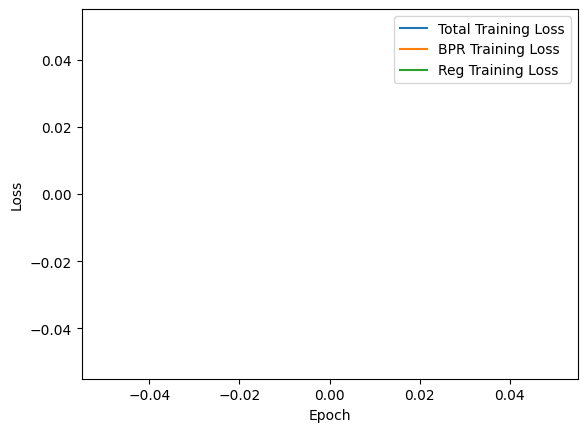

In [ ]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

This code creates a plot that shows how the different loss values change as the recommendation model (LightGCN) is trained over multiple epochs. The x-axis represents the number of epochs, and the y-axis represents the loss values. There are three lines on the plot, each corresponding to a different type of loss:

Total Training Loss: This line shows the overall loss during training, which includes both the BPR loss and the regularization loss.

BPR Training Loss: This line specifically shows the BPR loss, which is a key loss function used in recommendation systems.

Regularization Training Loss: This line represents the regularization loss, which helps prevent overfitting and keeps the model's parameters in check.

The plot provides a visual overview of how these loss values evolve during training, helping to monitor the training process and potentially identify issues or improvements.

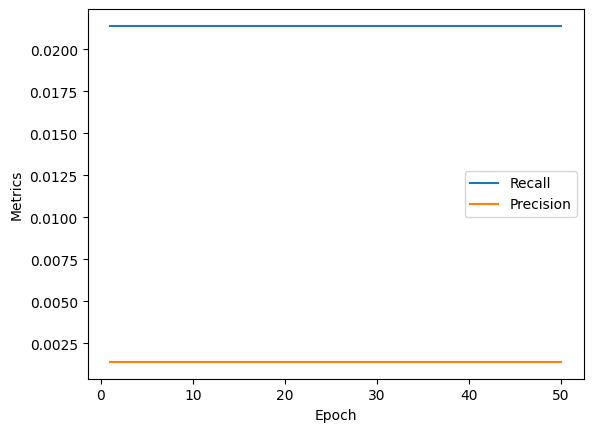

In [ ]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

This code plots the changes in the recall and precision metrics during the training of the LightGCN recommendation model. The x-axis represents epochs, and the y-axis represents the values of the metrics. It helps track how well the model's recommendations improve over training in terms of recall and precision.

### Train and eval NGCF

In [ ]:
ngcf = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([706, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


This code is creating a recommendation model that will learn to suggest items to users. The model is called NGCF, and it's designed to work with user and item data. The code prepares the model for training by setting up an optimizer, moving it to a specific device (like a graphics card), and then it shows the sizes of the different parts the model will learn about. It's like getting the model ready for learning and checking how much it needs to learn.

In [ ]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision = train_and_eval(ngcf, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/di

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]

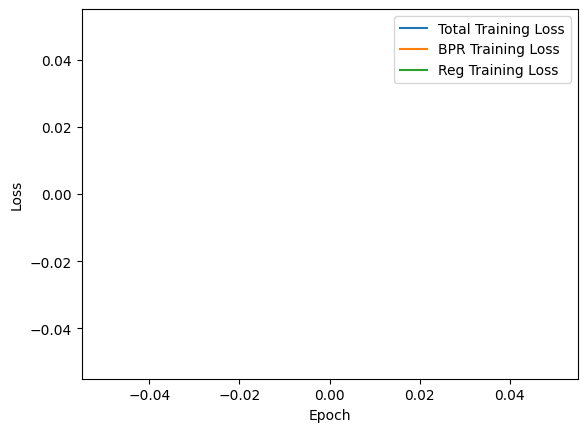

In [ ]:
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')
plt.plot(epoch_list, ngcf_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

This code is plotting the loss values during training for the NGCF recommendation model. It shows how the total training loss, the Bayesian Personalized Ranking (BPR) loss, and the regularization loss change over each epoch (a complete cycle of training data). The plot helps to understand how the model's performance evolves during training.

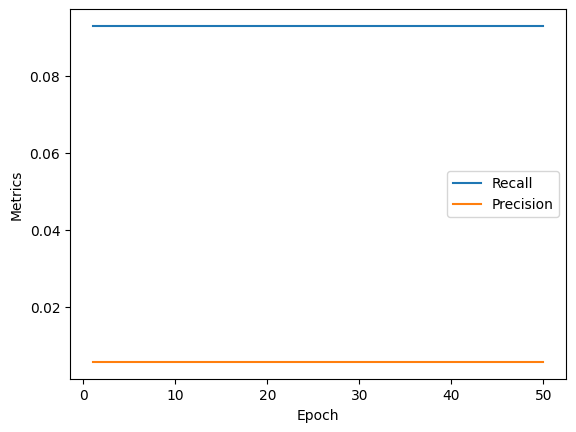

In [ ]:
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

This code is plotting the "Recall" and "Precision" metrics during training for the NGCF recommendation model. The "Recall" metric measures the proportion of relevant items that the model is able to recommend to users, and the "Precision" metric measures the proportion of recommended items that are actually relevant. This plot helps visualize how these metrics change as the model is trained over each epoch.

### Compare model performance

In [ ]:
max(light_precision), max(light_recall)

(0.0014, 0.0214)

In [ ]:
max(ngcf_precision), max(ngcf_recall)

(0.0057, 0.0929)

In [ ]:
def recommend_movies(user_id, user_Embed_wts, item_Embed_wts, n_items, K):
    user_idx = le_user.transform([user_id])[0]

    # Get the user's embedding
    user_emb = user_Embed_wts[user_idx].unsqueeze(0)

    # Compute the score of all items for the user
    relevance_score = torch.matmul(user_emb, torch.transpose(item_Embed_wts, 0, 1))

    # Sort the items based on relevance score and get the top K recommendations
    topk_indices = torch.topk(relevance_score, K).indices
    topk_item_ids = le_item.inverse_transform(topk_indices.view(-1).cpu().numpy())

    return topk_item_ids

# Replace 'lightgcn' and 'ngcf' with the respective trained models
user_id = 122  # Replace with the specific user ID for which you want recommendations
recommended_movies_lightgcn = recommend_movies(user_id, lightgcn.embedding.weight, lightgcn.embedding.weight[n_users:], n_items, K)
recommended_movies_ngcf = recommend_movies(user_id, ngcf.embedding.weight, ngcf.embedding.weight[n_users:], n_items, K)

print("Recommended movies (LightGCN):", recommended_movies_lightgcn)
print("Recommended movies (NGCF):", recommended_movies_ngcf)


Recommended movies (LightGCN): [ 174  626 1047 1028   26  264  439  568  285   32  407  417  194   99
  845  923  725  724  758 1220]
Recommended movies (NGCF): [  58  751  214 1153  333 1336  512  144  724  427  498  654  439 1061
  872   89   33   94  729   88]


This code defines a function to recommend movies for a given user based on trained embeddings from two different recommendation models: 'LightGCN' and 'NGCF'. The function computes relevance scores for all items, selects the top K items, and returns the recommended movie item IDs for the specified user. The recommended movies are then printed for both models.

In [ ]:
import torch
import pandas as pd

def recommend_movies(user_id, user_Embed_wts, item_Embed_wts, n_users, n_items, K):
    user_idx = le_user.transform([user_id])[0]

    # Get the user's embedding
    user_emb = user_Embed_wts[user_idx].unsqueeze(0)

    # Compute the score of all items for the user
    relevance_score = torch.matmul(user_emb, torch.transpose(item_Embed_wts, 0, 1))

    # Sort the items based on relevance score and get the top K recommendations
    topk_indices = torch.topk(relevance_score, K).indices
    topk_item_ids = le_item.inverse_transform(topk_indices.view(-1).cpu().numpy())

    return topk_item_ids

# Replace 'lightgcn' and 'ngcf' with the respective trained models
user_id = 123  # Replace with the specific user ID for which you want recommendations
recommended_movies_lightgcn = recommend_movies(user_id, lightgcn.embedding.weight, lightgcn.embedding.weight[n_users:], n_users, n_items, K)
recommended_movies_ngcf = recommend_movies(user_id, ngcf.embedding.weight, ngcf.embedding.weight[n_users:], n_users, n_items, K)

print("Recommended movies (LightGCN):", recommended_movies_lightgcn)
print("Recommended movies (NGCF):", recommended_movies_ngcf)


NameError: ignored

In [ ]:
# Assuming you have trained the models and have access to the learned user and item embeddings
# Replace 'lightgcn' and 'ngcf' with the respective trained models

def recommend_movies(user_id, user_embeddings, item_embeddings, n_items, K):
    # Get the user embedding for the specified user ID
    user_embedding = user_embeddings[user_id]

    # Compute the similarity scores (dot product) between the user embedding and all item embeddings
    similarity_scores = torch.matmul(user_embedding, item_embeddings.T)

    # Get the top-K item indices with the highest similarity scores
    top_item_indices = torch.argsort(similarity_scores, descending=True)[:K]

    # Return the top-K recommended movie IDs
    recommended_movie_ids = top_item_indices.tolist()

    return recommended_movie_ids

# Replace 'lightgcn' and 'ngcf' with the respective trained models
user_id = 123  # Replace with the specific user ID for which you want recommendations
recommended_movies_lightgcn = recommend_movies(user_id, lightgcn.embedding.weight[:n_users], lightgcn.embedding.weight[n_users:], n_items, K)
recommended_movies_ngcf = recommend_movies(user_id, ngcf.embedding.weight[:n_users], ngcf.embedding.weight[n_users:], n_items, K)

print("Recommended movies (LightGCN):", recommended_movies_lightgcn)
print("Recommended movies (NGCF):", recommended_movies_ngcf)


Recommended movies (LightGCN): [265, 242, 196, 149, 326, 380, 469, 321, 385, 22, 438, 447, 228, 387, 304, 301, 68, 353, 350, 413]
Recommended movies (NGCF): [12, 280, 151, 350, 287, 187, 357, 311, 252, 399, 326, 92, 235, 217, 81, 10, 295, 186, 225, 336]


## Paper References

1. Harper, F. Maxwell, and Konstan, Joseph A. “The MovieLensDatasets: History and Context.” ACM Transactions on Interactive Intelligence Systems (TiiS) 5, 4. 2015.
2. He, Xiangnan, et al. “LightGCN: Simplifying and powering graph convolution network for recommendation.” Proceedings of the 43rd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2020.
3. Wang, Xiang, et al. “Neural graph collaborative filtering.” Proceedings of the 42nd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2019.

## Code References

We thank the authors of the following codebases and notebooks, from which parts of this tutorial were inspired or adapted.

- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch

- https://github.com/gusye1234/LightGCN-PyTorch

- https://github.com/SytzeAndr/NGCF_RP32/blob/hand-in/NGCF.ipynb
